##MNIST

In [2]:
pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=0642d087db44936407193501e9e96887fe3156ee75593849aae7f7c79557706f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchviz import make_dot
import matplotlib.pyplot as plt

In [4]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [5]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.1.0+cu121
CUDA version: 12.1



In [6]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 117609633.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34306342.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72063805.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7904783.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



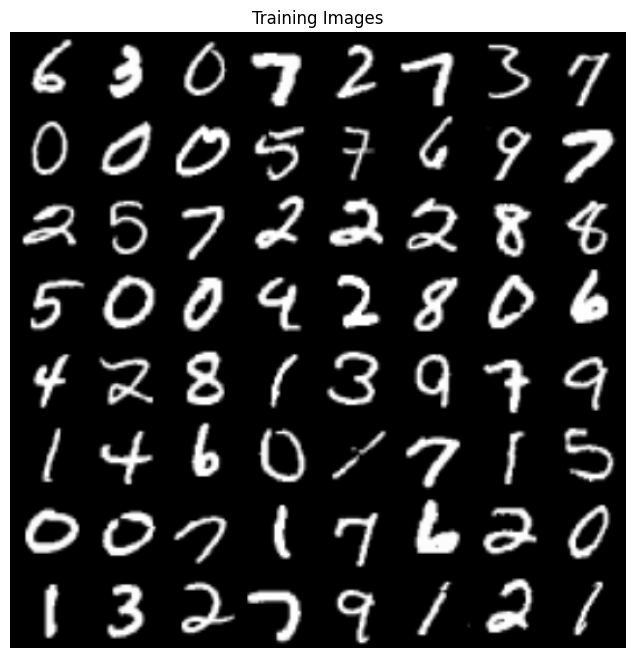

In [7]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [11]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


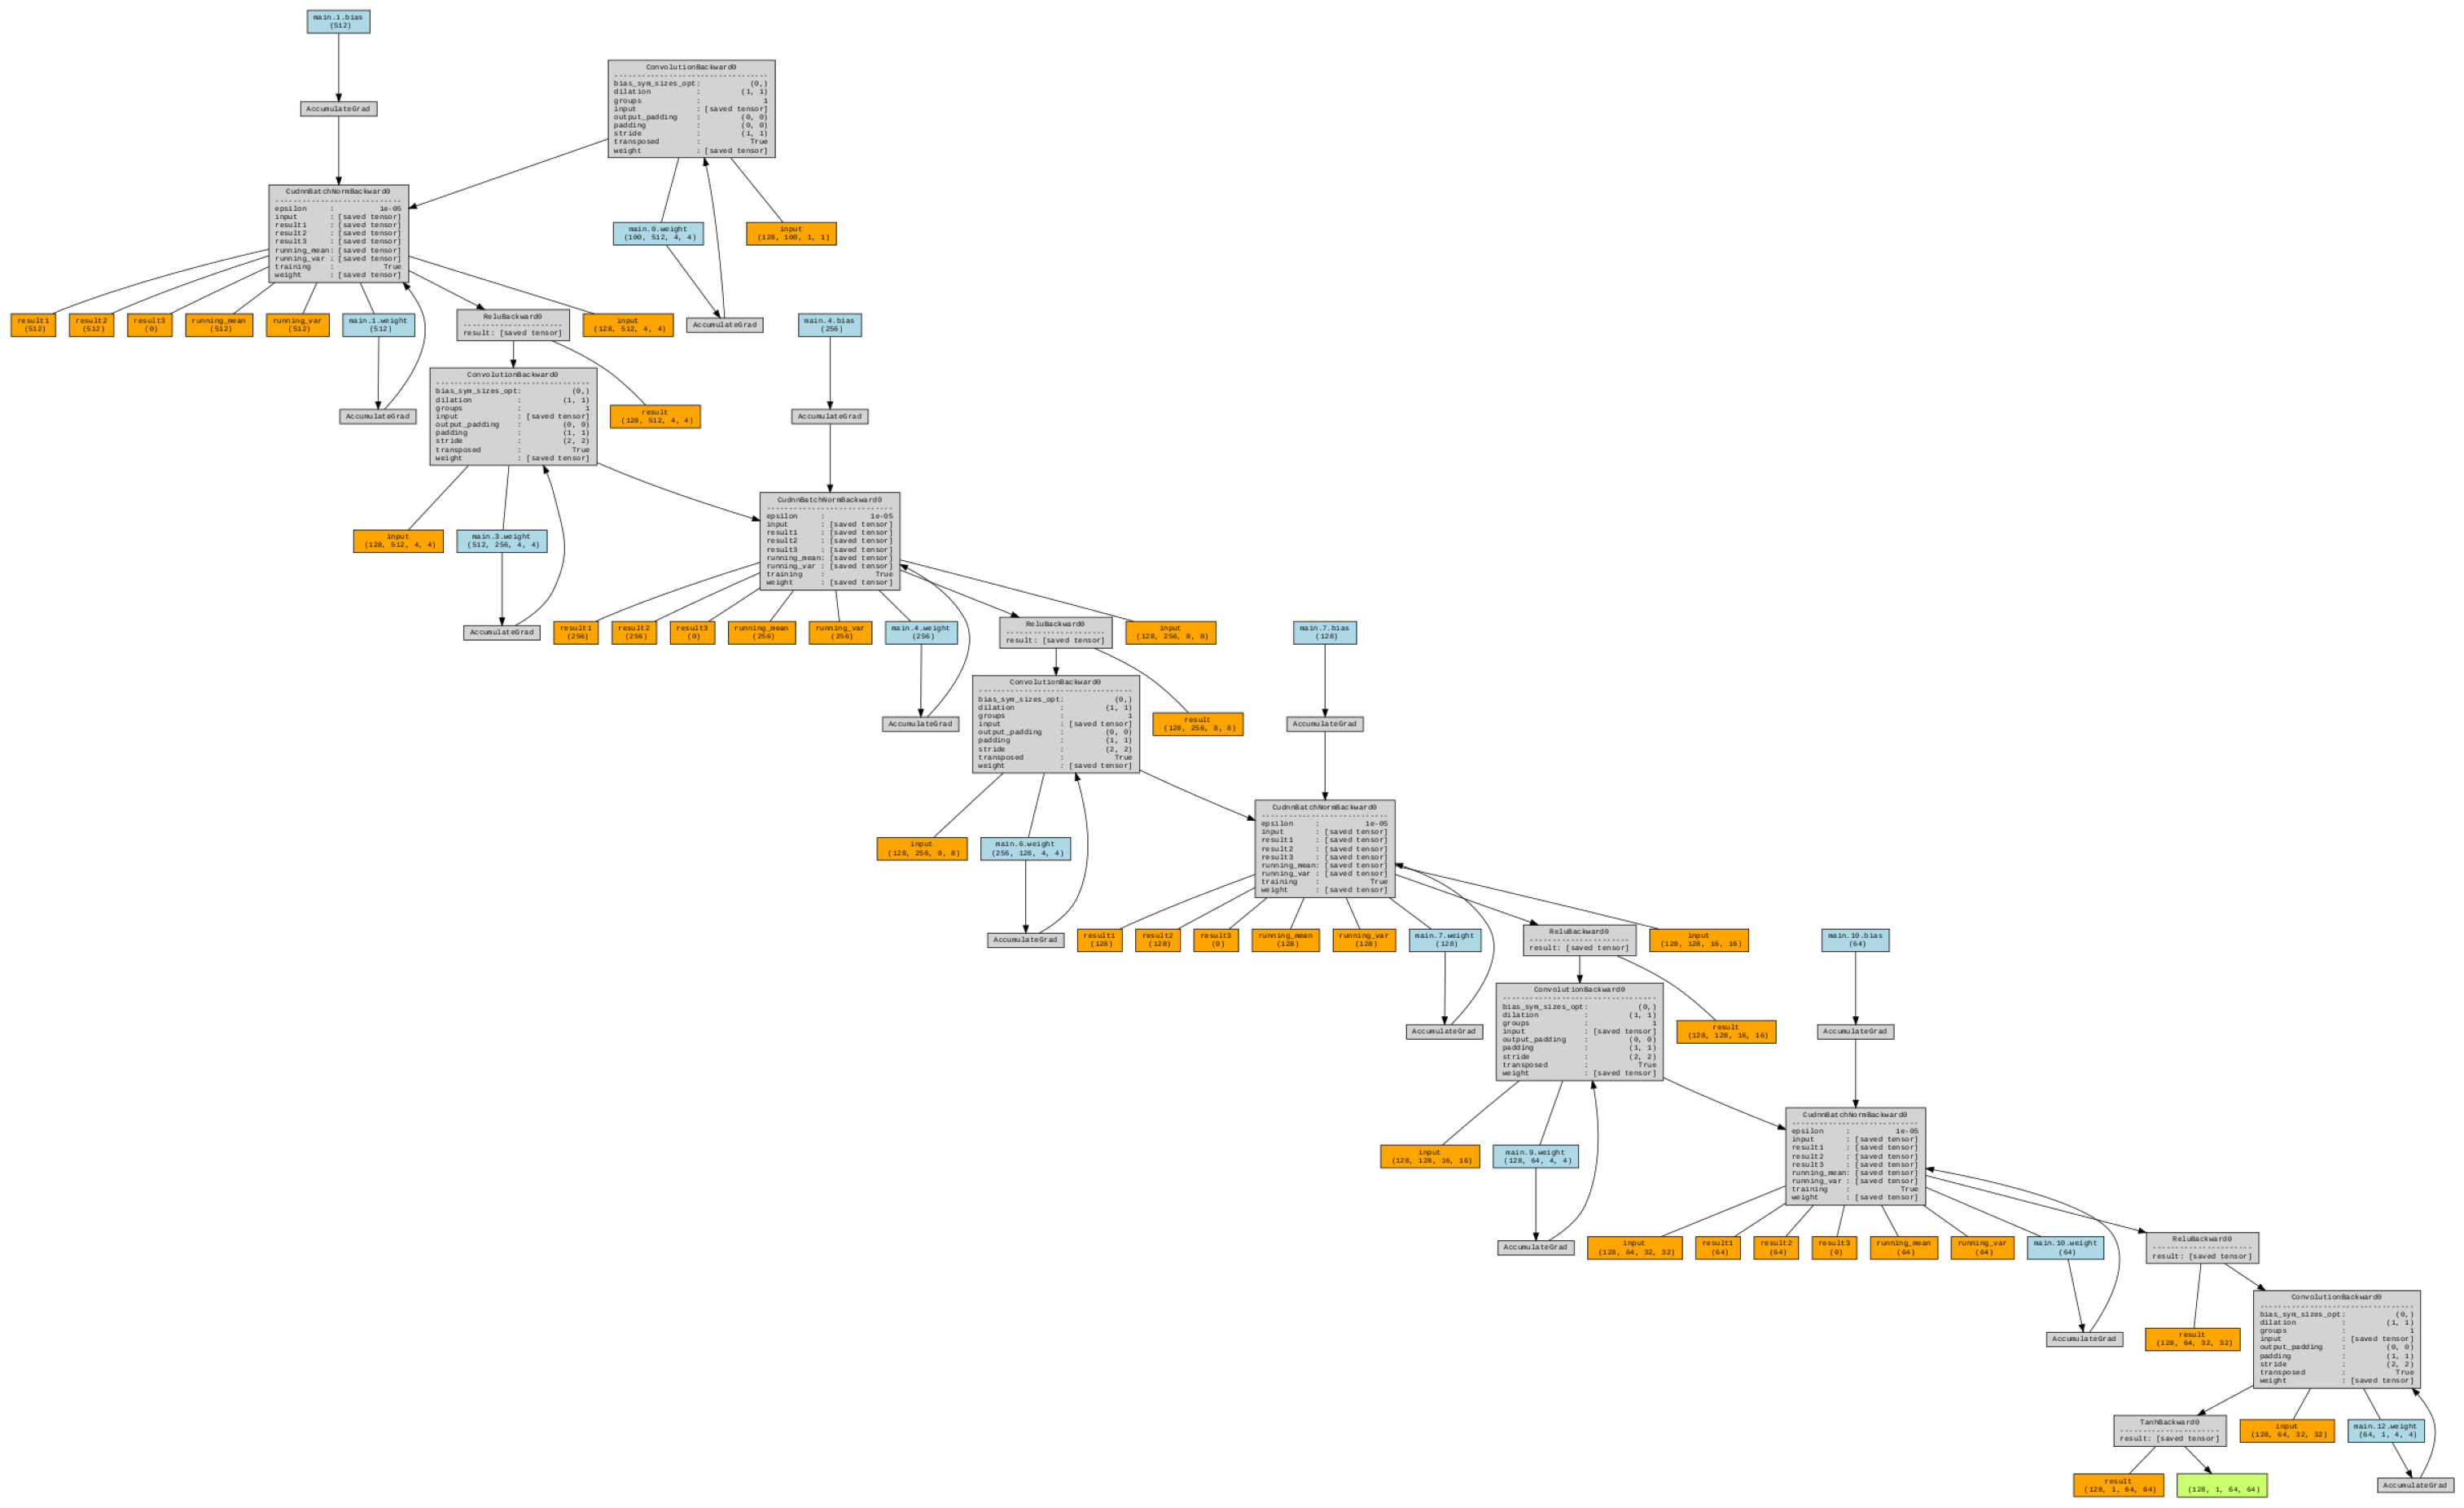

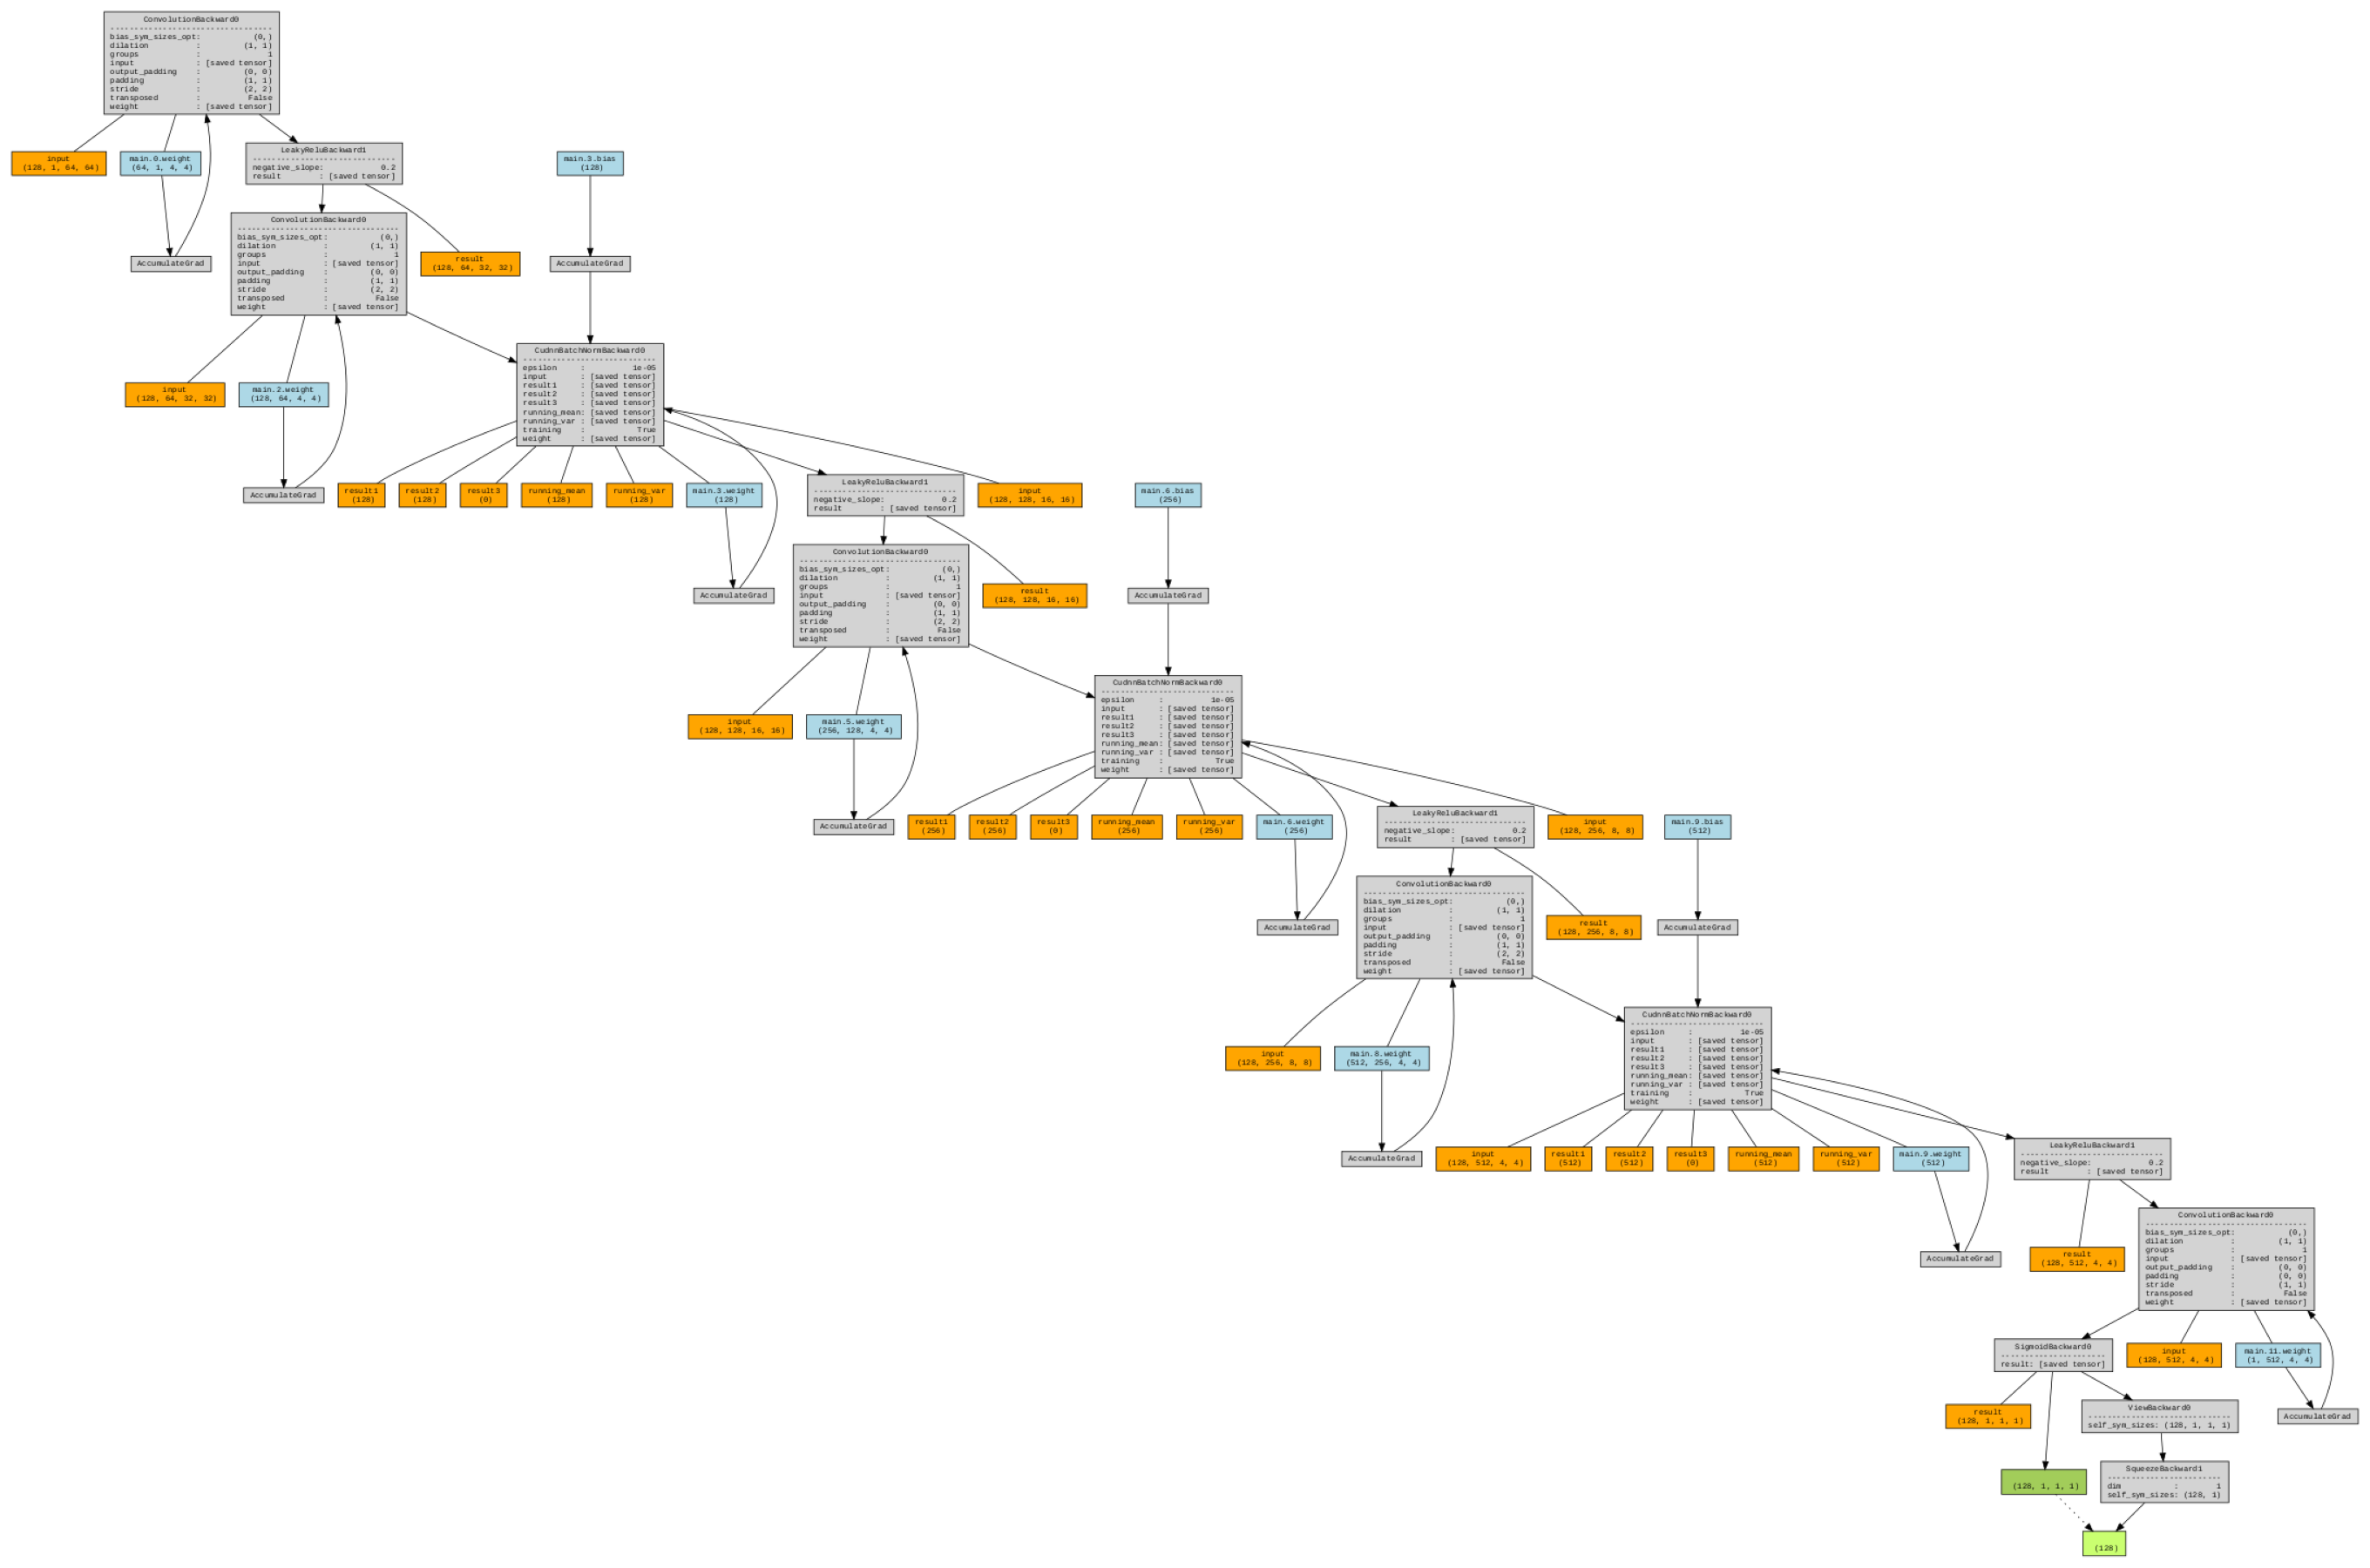

In [12]:
# Create dummy inputs for the generator and discriminator
z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)  # Generator input noise
real_images = torch.randn(BATCH_SIZE, IMAGE_CHANNEL, X_DIM, X_DIM, device=device)  # Example real images input for discriminator

# Perform a forward pass to get outputs for visualization
gen_output = netG(z)  # Output from the generator
disc_output = netD(real_images)  # Output from the discriminator using real images as dummy input

# Visualize the generator and discriminator using torchviz
gen_graph = make_dot(gen_output, params=dict(netG.named_parameters()), show_attrs=True, show_saved=True)
disc_graph = make_dot(disc_output, params=dict(netD.named_parameters()), show_attrs=True, show_saved=True)

# Display the graphs in the notebook
# For the generator
gen_graph.render("generator_visualization", format="png", cleanup=True)
# For the discriminator
disc_graph.render("discriminator_visualization", format="png", cleanup=True)

# Function to display images in the notebook
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

# Display the images
display_image_in_actual_size('generator_visualization.png')
display_image_in_actual_size('discriminator_visualization.png')

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 2.1629	Loss_G: 2.9035	D(x): 0.3946	D(G(z)): 0.6034 / 0.0781
[0/5][50/469]	Loss_D: 0.0129	Loss_G: 5.7697	D(x): 0.9942	D(G(z)): 0.0065 / 0.0051
[0/5][100/469]	Loss_D: 0.1286	Loss_G: 7.2674	D(x): 0.9306	D(G(z)): 0.0333 / 0.0019
[0/5][150/469]	Loss_D: 0.1187	Loss_G: 4.0038	D(x): 0.9403	D(G(z)): 0.0488 / 0.0266
[0/5][200/469]	Loss_D: 0.2866	Loss_G: 4.4241	D(x): 0.9110	D(G(z)): 0.1534 / 0.0198
[0/5][250/469]	Loss_D: 0.1406	Loss_G: 3.8076	D(x): 0.9389	D(G(z)): 0.0673 / 0.0353
[0/5][300/469]	Loss_D: 0.1862	Loss_G: 3.6285	D(x): 0.8943	D(G(z)): 0.0568 / 0.0388
[0/5][350/469]	Loss_D: 0.4354	Loss_G: 3.4193	D(x): 0.8874	D(G(z)): 0.2456 / 0.0450
[0/5][400/469]	Loss_D: 0.1339	Loss_G: 3.1356	D(x): 0.9289	D(G(z)): 0.0531 / 0.0548
[0/5][450/469]	Loss_D: 0.3490	Loss_G: 2.7390	D(x): 0.8579	D(G(z)): 0.1546 / 0.0858
[1/5][0/469]	Loss_D: 0.3095	Loss_G: 3.5236	D(x): 0.9606	D(G(z)): 0.2206 / 0.0407
[1/5][50/469]	Loss_D: 0.5408	Loss_G: 1.8536	D(x): 0.7491	D(G(z)): 

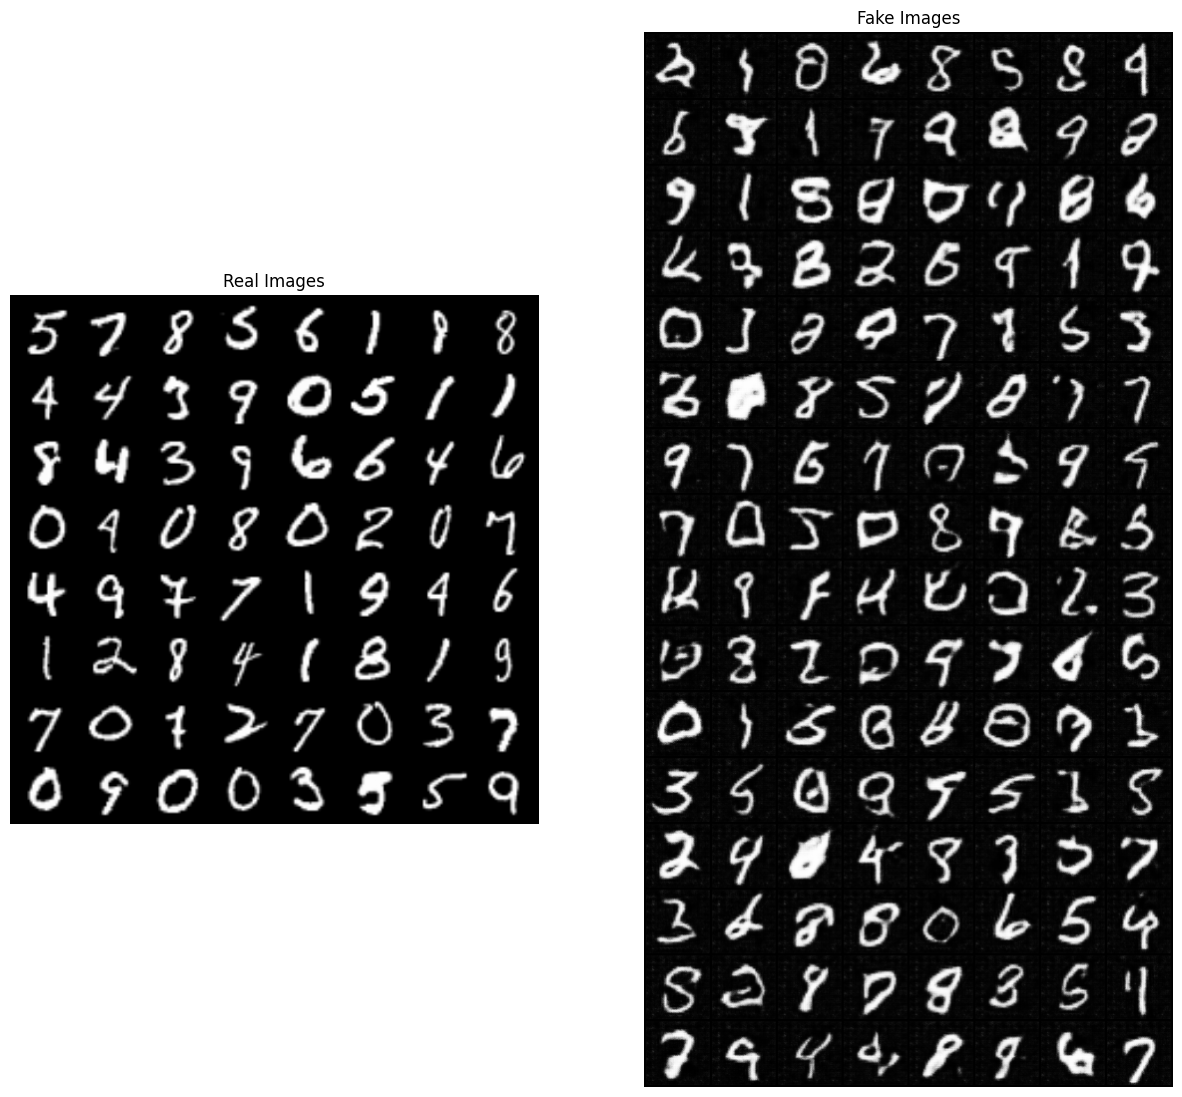

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

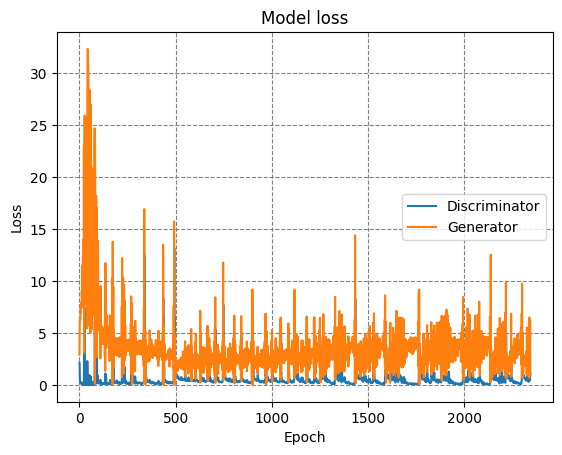

In [16]:
# plotting the metrics
plt.plot(D_losses)
plt.plot(G_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.grid(linestyle='--', color='gray')
plt.show()